In [1]:
# Imports
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import haversine as hs
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

# Set random state
random_state = 42

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
data = pd.read_csv('/kaggle/input/playground-series-s3e20/train.csv')

In [3]:
# EDA - look at the shape of the dataset
data.shape

(79023, 76)

In [4]:
data.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [5]:
# Understand data types
pd.set_option('display.max_rows', None)
data.dtypes

ID_LAT_LON_YEAR_WEEK                                         object
latitude                                                    float64
longitude                                                   float64
year                                                          int64
week_no                                                       int64
SulphurDioxide_SO2_column_number_density                    float64
SulphurDioxide_SO2_column_number_density_amf                float64
SulphurDioxide_SO2_slant_column_number_density              float64
SulphurDioxide_cloud_fraction                               float64
SulphurDioxide_sensor_azimuth_angle                         float64
SulphurDioxide_sensor_zenith_angle                          float64
SulphurDioxide_solar_azimuth_angle                          float64
SulphurDioxide_solar_zenith_angle                           float64
SulphurDioxide_SO2_column_number_density_15km               float64
CarbonMonoxide_CO_column_number_density         

In [6]:
# Understand the target variable
data['emission'].describe()

count    79023.000000
mean        81.940552
std        144.299648
min          0.000000
25%          9.797995
50%         45.593445
75%        109.549595
max       3167.768000
Name: emission, dtype: float64

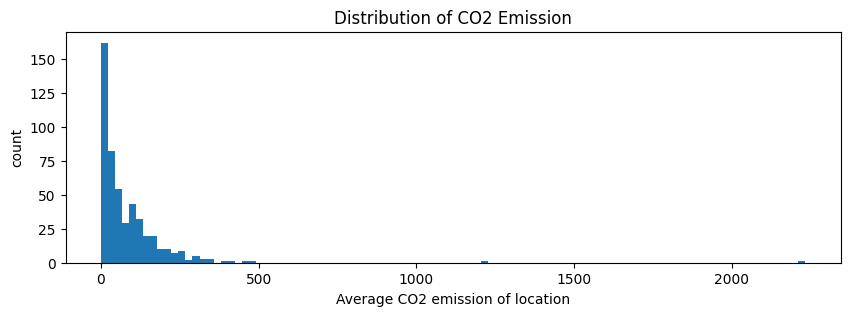

In [7]:
# Visualization of Target Variable Distribution
plt.figure(figsize=(10, 3))
plt.hist(data.groupby(['latitude', 'longitude']).emission.mean(), bins=100)
plt.title('Distribution of CO2 Emission')
plt.xlabel('Average CO2 emission of location')
plt.ylabel('count')
# plt.savefig("target_histogram.png", dpi=600, bbox_inches='tight')
plt.show()

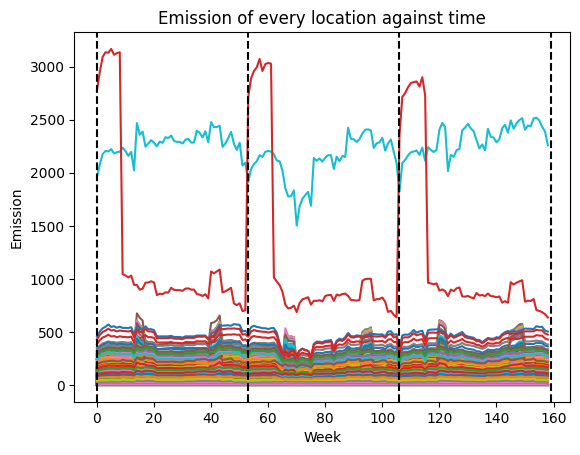

In [8]:
# Check the seasonality
for name, group in data.groupby(['latitude', 'longitude']):
    time_series = group['emission']
    plt.plot(range(len(time_series)), time_series)

# Year separator
for week in [0, 53, 106, 159]:
    plt.axvline(week, color='k', linestyle='--')

plt.title('Emission of every location against time')
plt.xlabel('Week')
plt.ylabel('Emission')
# plt.savefig("seasonality.png", dpi=600, bbox_inches='tight')
plt.show()

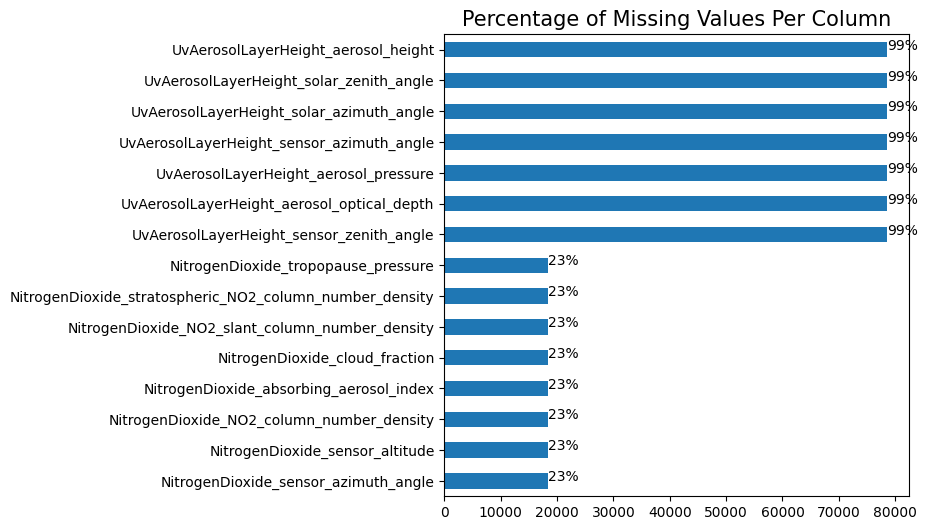

In [9]:
# Visualize the missing values
ax = data.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (6, 6))
plt.title('Percentage of Missing Values Per Column', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/data.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))
# plt.savefig('missing.png', dpi=300, bbox_inches='tight')
plt.show()

From the above plot, we can see that the CO2 emission is skewed and follows a long tail distribution

From the diagram above, we can see that there are two major outliers who have high CO2 emission. For the location labeled in red, we can also see that the emissions are significantly higher during start of the year.

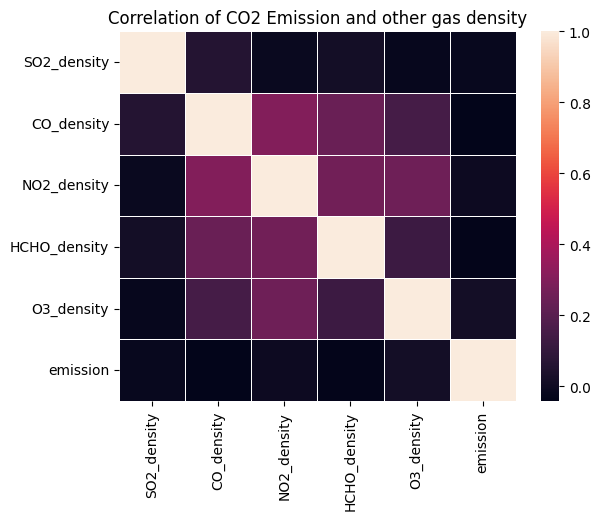

In [10]:
# Correlation of CO2 emission and other gas densities
# Rename columns for better heatmap display
data.rename(columns = {'SulphurDioxide_SO2_column_number_density':'SO2_density', 'CarbonMonoxide_CO_column_number_density': 'CO_density', 'NitrogenDioxide_NO2_column_number_density':'NO2_density', 'Formaldehyde_tropospheric_HCHO_column_number_density':'HCHO_density', 'Ozone_O3_column_number_density': 'O3_density'}, inplace = True)
density = data[['SO2_density', 'CO_density', 'NO2_density', 'HCHO_density', 'O3_density', 'emission']].corr()
ax = sns.heatmap(density, linewidth=0.5)
plt.title('Correlation of CO2 Emission and other gas density')
# plt.savefig('correlation.png', dpi=300, bbox_inches='tight')
plt.show()

From the correlation analysis of different gases against CO2, we can see that the data is too noisy, thus the modeling would be focused on predicting the CO2 emissions through time and location

In [11]:
# Using 2019, 2020 as training data and 2021 as test data
train = data[data['year'] != 2021]
test = data[data['year'] == 2021]
groups = train.year

In [12]:
# Only use time and location for training as gas-related data are mostly noises
train = train[['longitude', 'latitude', 'week_no', 'emission']]
test = test[['longitude', 'latitude', 'week_no', 'emission']]

In [13]:
# Preprocess - Feature Engineering
# Add clusters to group similar locations that are nearby
# Add feature of distance to the highest emission location
def feature_eng(train, test):
    
    # KMeans clustering by emission mean 
    cluster = train.groupby(by=['latitude', 'longitude'], as_index=False)['emission'].mean() 
    model = KMeans(n_clusters=12, max_iter=1000, random_state=random_state) 
    cluster['kmeans_group'] = model.fit_predict(cluster) 
    
    # Create distance to the highest emission location column
    max_lat_lon_emission = cluster.loc[cluster['emission']==cluster['emission'].max(), ['latitude', 'longitude']]
    cluster['distance_to_max_emission'] = cluster.apply(
        lambda x: hs.haversine((x['latitude'], x['longitude']), 
                               (max_lat_lon_emission['latitude'].values[0], 
                                max_lat_lon_emission['longitude'].values[0])), axis=1)
    
    # merge train and test with cluster
    train = train.merge(cluster[['latitude', 'longitude', 'kmeans_group', 'distance_to_max_emission']], on=['latitude', 'longitude'])
    test = test.merge(cluster[['latitude', 'longitude', 'kmeans_group', 'distance_to_max_emission']], on=['latitude', 'longitude'])
    
    return train, test

In [14]:
train, test = feature_eng(train, test)
train.head()

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


,longitude,latitude,week_no,emission,kmeans_group,distance_to_max_emission
0,29.29,-0.51,0,3.750994,0,207.84989
1,29.29,-0.51,1,4.025176,0,207.84989
2,29.29,-0.51,2,4.231381,0,207.84989
3,29.29,-0.51,3,4.305286,0,207.84989
4,29.29,-0.51,4,4.347317,0,207.84989


In [15]:
X_train = train.drop(['emission'], axis=1, inplace=False)
y_train = train['emission']
X_test = test.drop(['emission'], axis=1, inplace=False)
y_test = test['emission']

In [16]:
# Cross validation with LeaveOneGroupOut() splitting for time series
# Define a function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create a scorer using the RMSE function
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Save the standard deviation
models_std_rmse = []

def cross_val(model, param_grid, name = ''):
    logo = LeaveOneGroupOut()

    # GridSearch
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=rmse_scorer, cv=logo.split(X_train, y_train, groups=groups), n_jobs=-1)
    grid_search.fit(X_train, y_train)
    cv_results = grid_search.cv_results_
    best_index = grid_search.best_index_
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Sign reversal
    best_cv_score = -cv_results['mean_test_score'][best_index]
    best_cv_std = cv_results['std_test_score'][best_index]
    models_std_rmse.append(best_cv_std)
    print('mean of ' + name + ' best cross-validation score is ' + str(best_cv_score))
    print('standard deviation of ' + name + ' best cross-validation score is ' + str(best_cv_std))
    return best_model, best_params

In [17]:
#Model 1 - RandomForest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = random_state, n_jobs = -1)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
}
rf_best_model, rf_best_params = cross_val(rf, rf_param_grid, 'Random Forest')
rf_best_params

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


mean of Random Forest best cross-validation score is 29.13054778480319
standard deviation of Random Forest best cross-validation score is 0.12714474971749112


{'max_depth': None, 'n_estimators': 200}

In [18]:
#Model 2 - XGBoost
from xgboost import XGBRegressor
xgb = XGBRegressor(random_state = random_state, n_jobs = -1)
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [7, 9, 11],
    'learning_rate': [0.1, 0.01]
}
xgb_best_model, xgb_best_params = cross_val(xgb, xgb_param_grid, 'XGBoost')
xgb_best_params

mean of XGBoost best cross-validation score is 28.928472456399913
standard deviation of XGBoost best cross-validation score is 0.25594477053288145


{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200}

In [19]:
#Model 3 - Elastic Net Regression 
from sklearn.linear_model import ElasticNet
enet = ElasticNet()
enet_param_grid = {
    'alpha': [0.1, 1.0, 10.0],  
    'l1_ratio': [0.1, 0.5, 0.7, 0.9]
}
enet_best_model, enet_best_params = cross_val(enet, enet_param_grid, 'Elastic Net Regression')
enet_best_params

mean of Elastic Net Regression best cross-validation score is 132.46282525711132
standard deviation of Elastic Net Regression best cross-validation score is 5.014236496242184


{'alpha': 0.1, 'l1_ratio': 0.9}

In [20]:
#Model 4 - KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor()
neigh_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'p': [1, 2] # Distance metric (1 for Manhattan distance, 2 for Euclidean distance)
}
neigh_best_model, neigh_best_params = cross_val(neigh, neigh_param_grid, 'KNeighborsRegressor')
neigh_best_params

mean of KNeighborsRegressor best cross-validation score is 29.597315309476148
standard deviation of KNeighborsRegressor best cross-validation score is 0.10707636526841569


{'n_neighbors': 3, 'p': 1}

From the above cross validation scores, we can see that tree-based models would be more appropriate and accurate for this dataset

In [21]:
# Results
models = [
    ("Random Forest", rf_best_model),
    ("XGBoost", xgb_best_model),
    ("Elastic Net (Base Model)", enet_best_model), 
    ("KNeighborsRegressor", neigh_best_model)
]

models_mean_rmse = []

names = []
errors = []
for name, model in models:
    rmse_scores = []
    y_pred = model.predict(X_test)
    errors = y_test - y_pred
    mean_rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    names.append(name)
    models_mean_rmse.append(mean_rmse)

In [22]:
print(models_mean_rmse)
print(models_std_rmse)

[19.107093322992004, 19.878304039495248, 135.23275083956526, 19.28030629475265]
[0.12714474971749112, 0.25594477053288145, 5.014236496242184, 0.10707636526841569]


In [23]:
# Baseline Model - Simple Moving Average

window_size = 3

# Calculate Simple Moving Average (SMA)
sma_predictions = []
for i in range(len(y_test) - window_size):
    window = y_test[i:i + window_size]
    sma = np.mean(window)
    sma_predictions.append(sma)
baseline_rmse = mean_squared_error(y_test[:-window_size], sma_predictions, squared=False)
print(baseline_rmse)

26.35461424049772


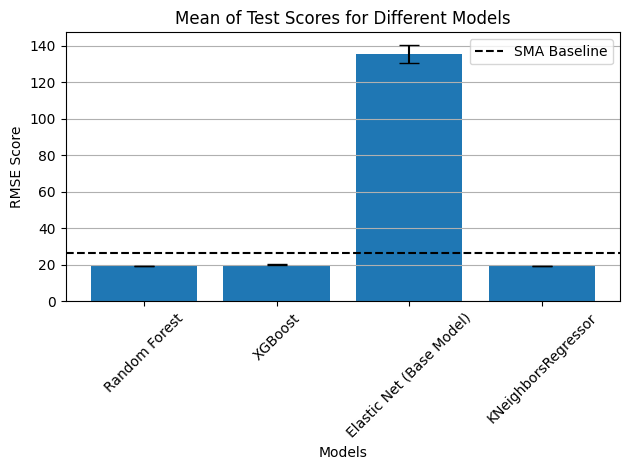

In [24]:
plt.bar(names, models_mean_rmse, yerr=models_std_rmse, capsize=7)
plt.xlabel('Models')
plt.ylabel('RMSE Score')
plt.title('Mean of Test Scores for Different Models')
plt.xticks(rotation=45)
plt.axhline(baseline_rmse, color='k', linestyle='--', label = "SMA Baseline")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
# plt.savefig("results.png", dpi=300)
plt.show()

From the above test results, we can see that Random Forest is the most promising model with its lowest RMSE score, thus further model inspection will be conducted

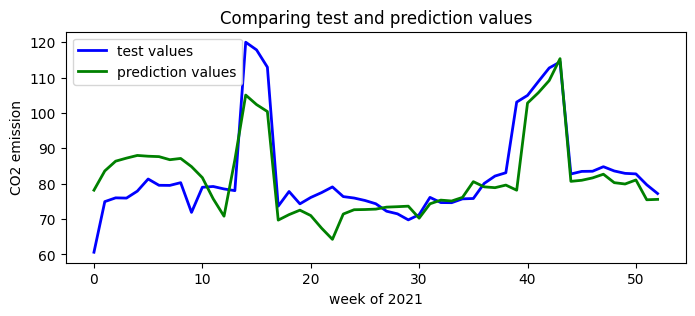

In [25]:
# Compared the predicted data and the real data
y_pred = pd.Series(rf_best_model.predict(X_test), index=X_test.index)
plt.figure(figsize=(8, 3))
plt.title("Comparing test and prediction values")
plt.xlabel('week of 2021')
plt.ylabel('CO2 emission')
plt.plot(range(53), y_test.groupby(test.week_no).mean(), label='test values', lw=2, color='b')
plt.plot(range(53), y_pred.groupby(test.week_no).mean(), label='prediction values', lw=2, color='g')
plt.legend()
# plt.savefig('comparison.png', dpi=300, bbox_inches='tight')
plt.show()

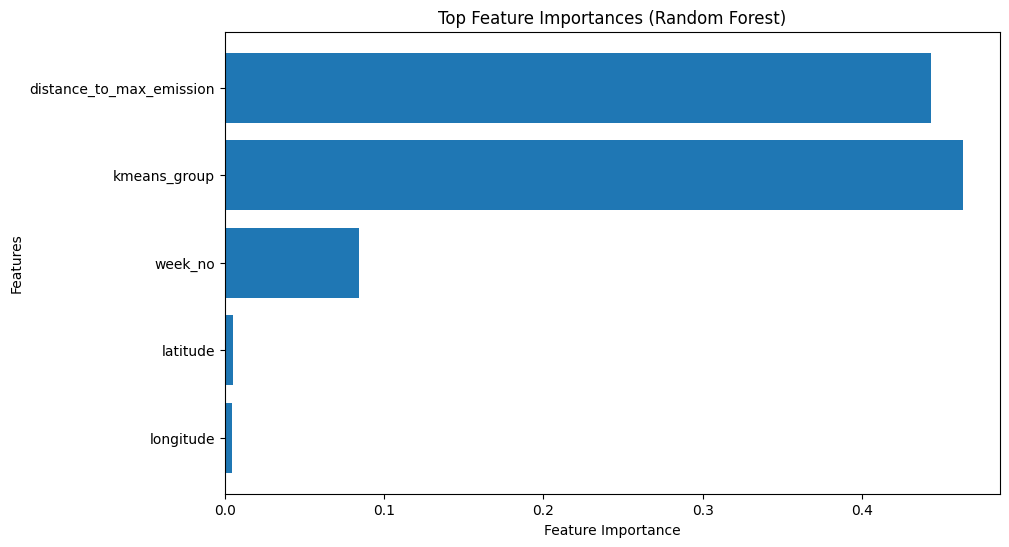

In [26]:
# Model Inspection & Interpretability
feature_importances = rf_best_model.feature_importances_

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), feature_importances, align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top Feature Importances (Random Forest)')
# plt.savefig("feature_importance.png", dpi=300)
plt.show()

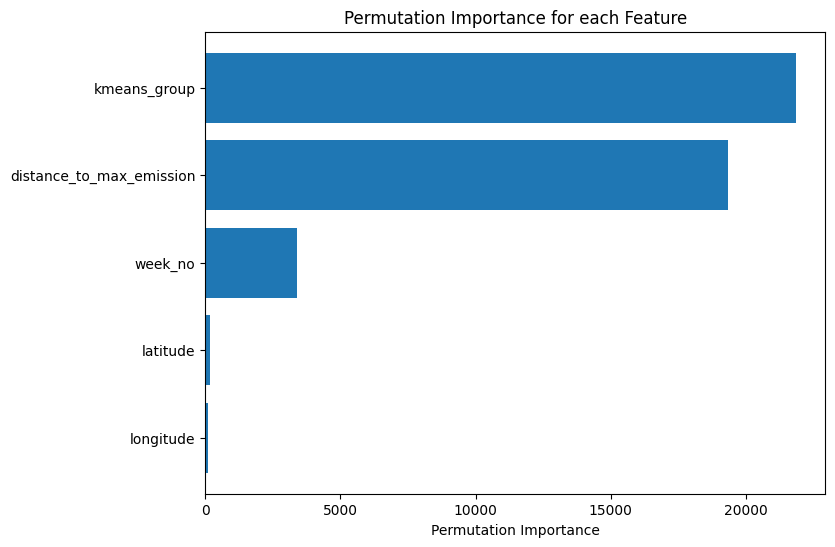

In [27]:
results = permutation_importance(rf_best_model, X_test, y_test, scoring='neg_mean_squared_error', n_repeats=10, random_state=random_state)
feature_names = X_test.columns
# Extracting and plotting feature importances
sorted_idx = results.importances_mean.argsort()
plt.figure(figsize=(8, 6))
plt.barh(range(X_test.shape[1]), results.importances_mean[sorted_idx], align='center')
plt.yticks(range(X_test.shape[1]), [feature_names[i] for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance for each Feature')
plt.savefig('permutation_importance.png', dpi=300, bbox_inches='tight')
plt.show()

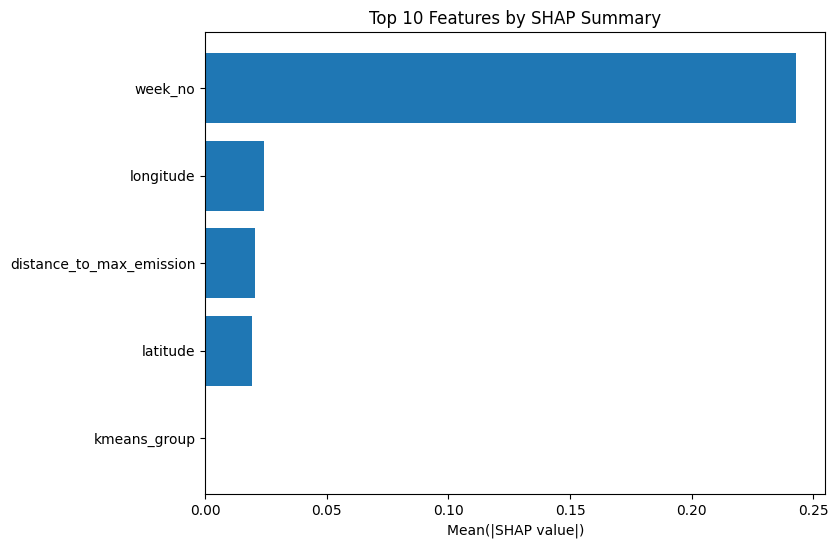

In [28]:
# Shap Summary - Limited to first 100 rows due to computation limits
# If there are more rows, it is very likely for the kernel to die
shap.initjs()
explainer = shap.Explainer(rf_best_model, X_test[:100])
shap_values = explainer.shap_values(X_test[:100])
shap_summary = np.abs(shap_values).mean(axis=0)
indcs = np.argsort(shap_summary)
plt.figure(figsize=(8, 6))
plt.barh(feature_names[indcs], shap_summary[indcs])
plt.xlabel('Mean(|SHAP value|)')
plt.title('Top 10 Features by SHAP Summary')
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
idx = 1
shap.force_plot(explainer.expected_value, shap_values[idx, :], X_test.iloc[idx, :], feature_names=feature_names)

In [30]:
idx = 55
shap.force_plot(explainer.expected_value, shap_values[idx, :], X_test.iloc[idx, :], feature_names=feature_names)